# Causal Inference using Random Walks and Bootstrap
## Use case: Impact of Email Marketing on Sales
### Source: <a href="https://medium.com/@carlangastr/combining-random-walks-and-bootstrap-for-causal-inference-analysis-on-time-series-2ca89f95bbe6">Medium Article</a>

In [28]:
# Library updates
!pip3 install -U seaborn

  Using cached seaborn-0.12.2-py3-none-any.whl (293 kB)
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.12.0
    Uninstalling seaborn-0.12.0:
      Successfully uninstalled seaborn-0.12.0


In [42]:
# Installing required libraries
!pip install tqdm

### Setting up

In [2]:
# Importing libraries
from tscausalinference import synth_dataframe, sensitivity
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
# Enviroment setup
# sns.set_theme()
# sns.set(style="darkgrid")
# sns.set_context("notebook")

In [4]:
# Create a dataframe populated with synthetic data
synth = synth_dataframe()
df = synth.DataFrame()

Min date: 2022-01-01 00:00:00
Max date: 2022-12-31 00:00:00
Day where effect was injected: 2022-12-17 00:00:00
Power of the effect: 15.0%


### Explanatroy Data Analysis (EDA)

In [3]:
df = pd.read_csv("sales_dataset.csv")

In [4]:
df.head(10)

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,05/02/2010,24924.50,False
1,1,1,12/02/2010,46039.49,True
2,1,1,19/02/2010,41595.55,False
3,1,1,26/02/2010,19403.54,False
4,1,1,05/03/2010,21827.90,False
5,1,1,12/03/2010,21043.39,False
6,1,1,19/03/2010,22136.64,False
7,1,1,26/03/2010,26229.21,False
8,1,1,02/04/2010,57258.43,False
9,1,1,09/04/2010,42960.91,False


In [5]:
df.dtypes

Store             int64
Dept              int64
Date             object
Weekly_Sales    float64
IsHoliday          bool
dtype: object

In [6]:
#df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%y')
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True, infer_datetime_format=True)

In [7]:
df.dtypes

Store                    int64
Dept                     int64
Date            datetime64[ns]
Weekly_Sales           float64
IsHoliday                 bool
dtype: object

In [8]:
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [9]:
df['Store'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45])

In [10]:
df['Dept'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 40, 41, 42, 44, 45, 46, 47, 48, 49, 51, 52, 54, 55, 56,
       58, 59, 60, 67, 71, 72, 74, 77, 78, 79, 80, 81, 82, 83, 85, 87, 90,
       91, 92, 93, 94, 95, 96, 97, 98, 99, 39, 50, 43, 65])

#### Filter out our df to narrow down the scope of the study

In [11]:
depts = [1,2,3,4]
df_filtered = df.query(f'Dept.isin({depts}) & Store == 1')

In [12]:
df_filtered['Dept'].unique()

array([1, 2, 3, 4])

In [13]:
df_filtered['Store'].unique()

array([1])

In [14]:
df_filtered = df_filtered.query('~IsHoliday')

In [15]:
df_filtered.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False
5,1,1,2010-03-12,21043.39,False


In [16]:
# Now we don't need the IsHoliday column, so let's drop it
df_filtered.drop(columns=['IsHoliday'], axis=1, inplace=True)
df_filtered.head()

,Store,Dept,Date,Weekly_Sales
0,1,1,2010-02-05,24924.50
2,1,1,2010-02-19,41595.55
3,1,1,2010-02-26,19403.54
4,1,1,2010-03-05,21827.90
5,1,1,2010-03-12,21043.39


In [17]:
df_filtered['Dept']==1

0       True
2       True
3       True
4       True
5       True
       ...  
567    False
568    False
569    False
570    False
571    False
Name: Dept, Length: 532, dtype: bool

#### Visualization

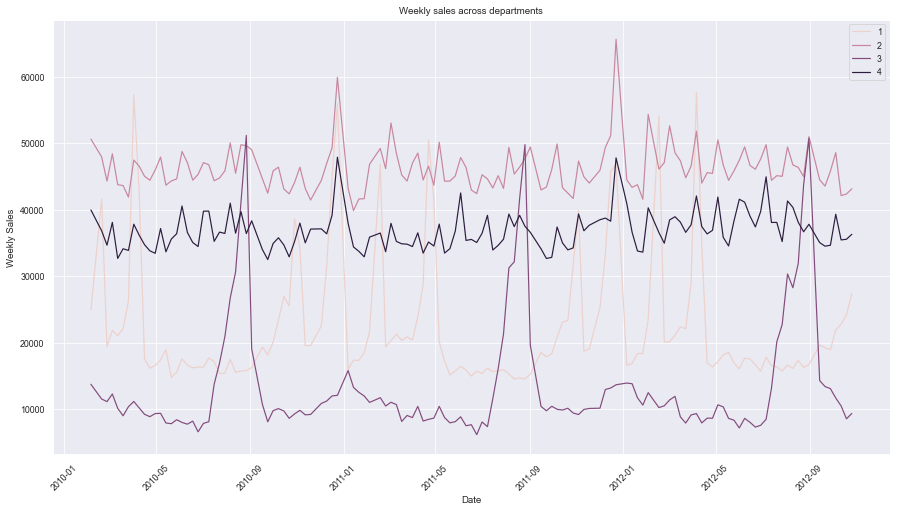

In [18]:
# Add titles and labels
plt.figure(figsize=(15, 8))
plt.title('Weekly sales across departments')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')

# Create a line plot of weekly sales per department
ax = sns.lineplot(x=df_filtered['Date'], y=df_filtered['Weekly_Sales'], hue=df_filtered['Dept'])

# set xticks to show every 4th label
# n = 4
# xticks = ax.get_xticks()
# ax.set_xticks(xticks[::n])
# ax.set_xticklabels(df_filtered['Date'][::n], rotation=45, ha='right')

# rotate the x-axis tick labels by 45 degrees
plt.xticks(rotation=45)

# Display plot
plt.legend()
plt.show()

### Regressor Selection

In [19]:
# Double check we don't have any missing values
print(df_filtered['Weekly_Sales'].isna().sum())

0


In [20]:
df_filtered.dtypes

Store                    int64
Dept                     int64
Date            datetime64[ns]
Weekly_Sales           float64
dtype: object

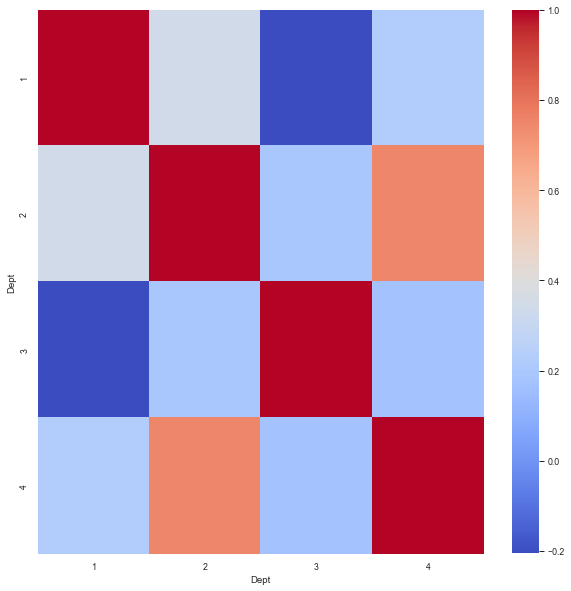

In [21]:
# Calculate the correlation matrix
sales_pivot = df_filtered.pivot_table(values='Weekly_Sales', index='Date', columns='Dept', aggfunc=np.sum)
corr = sales_pivot.corr()

fig, ax = plt.subplots(figsize=(10, 10))

# Plot the heatmap with the correlation values
sns.heatmap(corr, cmap='coolwarm')

Based on the heatmap above, there is a relatively strong positive correlation in sales between departments 2 and 4.

### Model Senstivity

In [23]:
df_causal = df_filtered.pivot(index='Date', columns='Dept', values='Weekly_Sales')

In [24]:
df_causal.head()

Dept,1,2,3,4
Date,,,,
2010-02-05,24924.50,50605.27,13740.12,39954.04
2010-02-19,41595.55,47928.89,11523.47,36826.95
2010-02-26,19403.54,44292.87,11135.17,34660.16
2010-03-05,21827.90,48397.98,12275.58,38086.19
2010-03-12,21043.39,43751.94,10123.45,32668.67


In [29]:
df_causal.rename_axis("ds")

Dept,1,2,3,4
ds,,,,
2010-02-05,24924.50,50605.27,13740.12,39954.04
2010-02-19,41595.55,47928.89,11523.47,36826.95
2010-02-26,19403.54,44292.87,11135.17,34660.16
2010-03-05,21827.90,48397.98,12275.58,38086.19
2010-03-12,21043.39,43751.94,10123.45,32668.67
...,...,...,...,...
2012-09-28,18947.81,45784.76,13085.95,34647.33
2012-10-05,21904.47,48577.08,11676.98,39311.93
2012-10-12,22764.01,42112.67,10487.17,35446.18


In [30]:
model_check = sensitivity(
    df=df_causal,
    test_period=['2012-02-28"', '2012-04-01'],
    cross_validation_steps=10,
    alpha=0.05,
    model_params={'changepoint_range': [0.85,0.50],
                  'changepoint_prior_scale': [0.05, 0.50]},
    regressors=['regressor2', 'regressor1'],
    verbose=True,
    autocorrelation = False,
    n_samples=1000)
model_check.run(prior = False)
model_check.plot()

ValueError: df must contain columns named 'ds' and 'y'

### Data Prep & Feature Engineering

To prepare the date for causal inference analysis, we need mimic the intervention of a marketing campagin. This will be done by imposing a marketing campain on one of the departments for a predefiend time interval.